In [1]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from scipy import stats
from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
#from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation

from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [2]:
sns.__version__

'0.11.2'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_File = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Data/NBA_PLATCOV_Trial.csv'
Data_df = pd.read_csv(data_File)

NBA = Data_df[Data_df.cat_Cohort == 'NBA']
PLATCOV_Cntrl = Data_df[Data_df.cat_Cohort == 'PLATCOV']
PLATCOV_Trtmnt = Data_df[Data_df.cat_Cohort == 'PLATCOV_trtmnt']

IDs_Tot = Data_df.ID.unique()
IDs_NBA = NBA.ID.unique()
IDs_Cntrl = PLATCOV_Cntrl.ID.unique()
IDs_trtmnt = PLATCOV_Trtmnt.ID.unique()

print(IDs_Cntrl[24])

IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Projects/NBA_Omicron_Platcov_Trial_tau_Cov_prf_est/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Projects/NBA_Omicron_Platcov_Trial_tau_Cov_prf_est/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)


Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'

Popparameters_PK = pd.read_csv(Popparameters_U_file)

PLT-TH1-388


In [5]:
LOD = 1.261

In [6]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [7]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [8]:
def PKPDParams(Popparameters, GetPopParams, GetParamsOmega, Emax, IC50, Hill, dose, PDOm):
    
    param_Order = ['ka', 'k12', 'k21', 'kcl', 'Vol', 'Emax', 'IC50', 'Hill']
    PKparams = GetPopParams(Popparameters, dose)
    PKparams_Val = PKparams['ka'], PKparams['kPL'], PKparams['kLP'], PKparams['kCl'],PKparams['Vol']
    PDparams = Emax, IC50, Hill
    PKPDparams = np.hstack((PKparams_Val, PDparams))
    
    PKOm = GetParamsOmega(Popparameters, dose)
    PKOm_Val = 0, 0, 0, 0, 0
    #PKOm['ka'], PKOm['kPL'], PKOm['kLP'], PKOm['kCl'],PKOm['Vol']
    PKPDOm = np.hstack((PKOm_Val, PDOm))
    eta = np.random.normal(np.zeros(len(PKPDOm)), PKPDOm, len(PKPDOm))
    PKPDInd = PKPDparams*np.exp(eta)
    if PKPDInd[5]>1:
        PKPDInd[5]=1
    return dict(zip(param_Order, PKPDInd))

In [9]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20, 'prf': 'logNormal'})


In [10]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.0, 0.0, 0.0
MolMass = 499.5   #g/Mol


In [11]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [12]:
    
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 30 #duration of simulation 30 days after symptom onset. 
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes[0])
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, MolMass)
        return t, y, dosetimes

In [13]:
def SimulateTreatment(VLPKPD, init, tzero, dt, tend, params, PKPDInd, dose, dosetimes, PotRed, MolMass):
    #Nirmatrelvir PD parameters
    E_max = PKPDInd['Emax']
    Hill_Coeff = PKPDInd['Hill']
    IC50 = PotRed*PKPDInd['IC50']

    #Nirmatrelvir PK Parameters for each individual
    ka = PKPDInd['ka']
    k12 = PKPDInd['k12']
    k21 = PKPDInd['k21']
    kcl = PKPDInd['kcl']
    Vol = PKPDInd['Vol']
    params_local = params.copy()
    params_local.extend([ka, k12, kcl, k21,Vol, MolMass, E_max, IC50, Hill_Coeff])
    args = tuple(params_local)
  
    if tzero==dosetimes[0]:
        for j in range(0,len(dosetimes)-1):
            init[5] = init[5] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            init = ytemp[-1,:].T
            if j==0:
                y= ytemp.copy()
                t= ttemp.copy()
            else:
                y = np.concatenate((y,ytemp), axis=0)
                t = np.concatenate((t,ttemp))
    else:       
        
        # simulate infection from tzero up to 1st dose
        t = np.arange(tzero, dosetimes[0],dt)
        # simulate using scipy integrate
        y = spi.odeint(VLPKPD, init, t, args = args)
   
        ytemp = y.copy()

        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init = ytemp[-1,:].T
            init[5] = init[5] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
        
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            t=np.concatenate((t,ttemp))
            y=np.concatenate((y,ytemp),axis=0)        
    #simulate until tend
    init = ytemp[-1,:].T
    init[5] = init[5] + dose 
    ttemp = np.arange(dosetimes[-1],tend,dt)
    ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
    t=np.concatenate((t,ttemp))
    y=np.concatenate((y,ytemp),axis=0)  
    return t, y

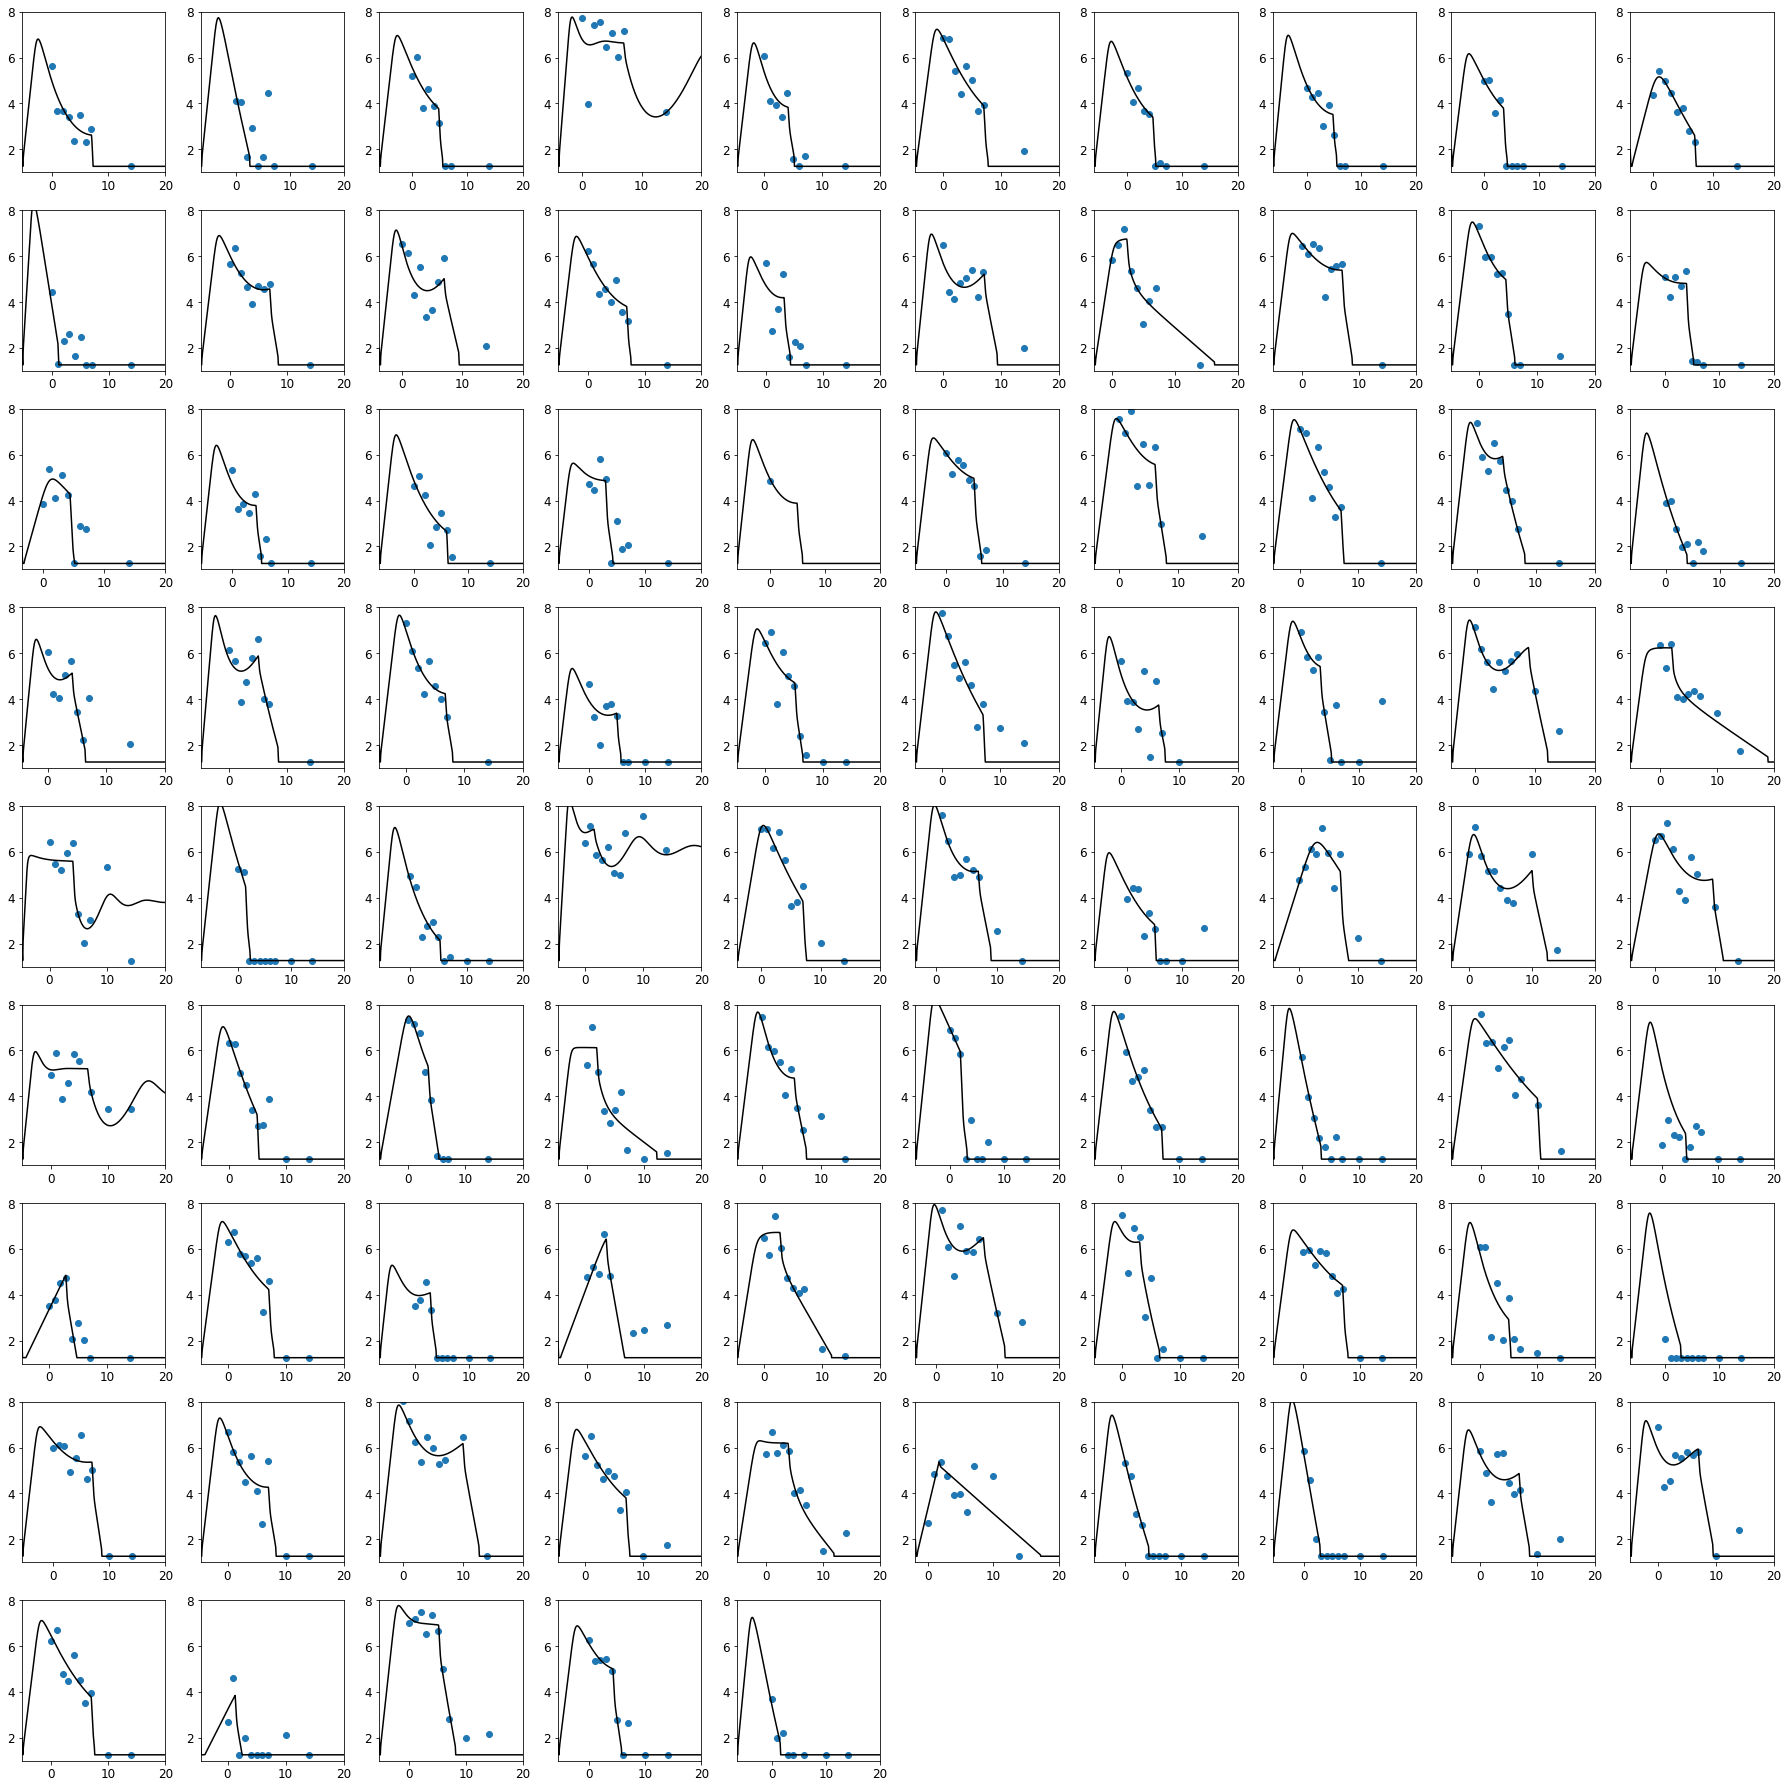

In [14]:
fig = plt.figure(figsize = (25,25))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Cntrl
dose = 0
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)
for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             param_dict[idi]['prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = PLATCOV_Cntrl[PLATCOV_Cntrl.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**LOD))
        plt.subplot(9,10, idi+1)
        plt.plot(data_t, data_y, 'o')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1,8])
      #  plt.title(ID)
        plt.tight_layout()

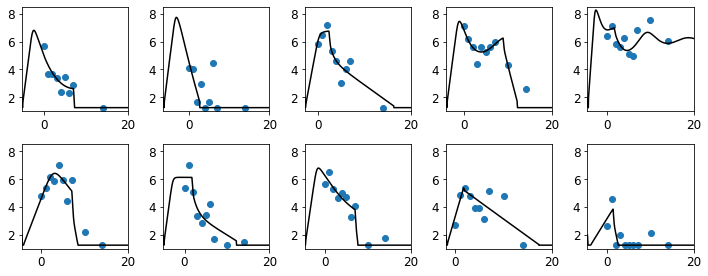

In [16]:
fig = plt.figure(figsize = (10,4))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_Cntrl
dose = 0
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)
IDs = ['PLT-TH1-275', 'PLT-TH1-280', 'PLT-TH1-345', 'PLT-TH1-474', 'PLT-TH1-513', 
       'PLT-TH1-637', 'PLT-TH1-608', 'PLT-TH1-613', 'PLT-TH1-493', 'PLT-TH1-456']
idis = [i for i in range(len(Cohort)) if Cohort[i] in IDs]
i=0
for idi, ID, TrtmntStrtDay in zip(idis, Cohort[idis], TreatmntStrtDay[idis]):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             param_dict[idi]['prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = PLATCOV_Cntrl[PLATCOV_Cntrl.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**LOD))
        plt.subplot(2,5, i+1)
        plt.plot(data_t, data_y, 'o')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1,8.5])
       # plt.title(ID)
        plt.tight_layout()
        i=i+1

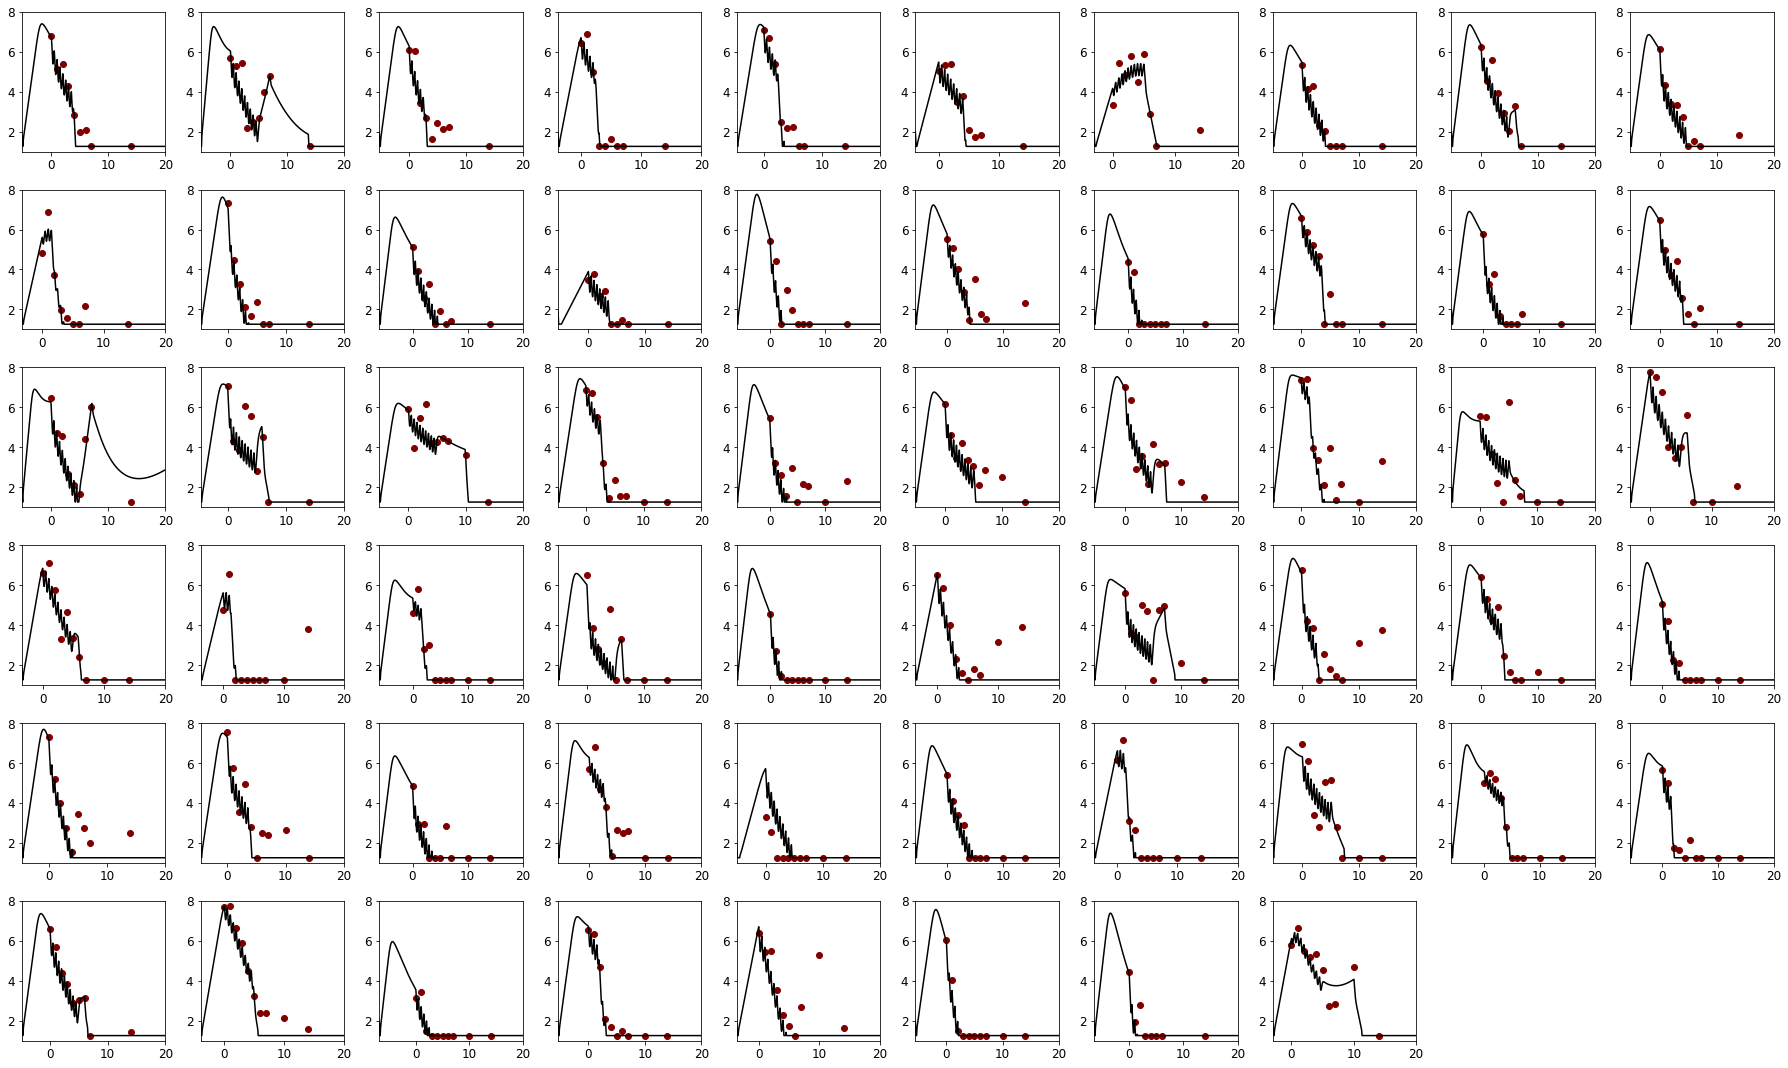

In [15]:
fig = plt.figure(figsize = (25,15))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_trtmnt
dose = 300
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)
for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             param_dict[idi]['prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = PLATCOV_Trtmnt[PLATCOV_Trtmnt.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**LOD))
        plt.subplot(6,10, idi+1)
        plt.plot(data_t, data_y, 'o', color = 'maroon')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1, 8])
       # plt.title(ID)
        plt.tight_layout()
    

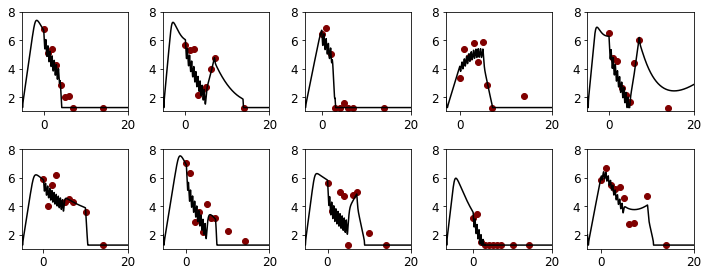

In [18]:
fig = plt.figure(figsize = (10,4))
plt.rcParams.update({'font.size': 12})
Cohort = IDs_trtmnt
dose = 300
TreatmntStrtDay = np.zeros(len(Cohort))
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)
IDs = ['PLT-TH1-274', 'PLT-TH1-298', 'PLT-TH1-305', 'PLT-TH1-325', 'PLT-TH1-464', 
       'PLT-TH1-542', 'PLT-TH1-653', 'PLT-TH1-429', 'PLT-TH1-415', 'PLT-TH1-619']
idis = [i for i in range(len(Cohort)) if Cohort[i] in IDs]
i=0
for idi, ID, TrtmntStrtDay in zip(idis, Cohort[idis], TreatmntStrtDay[idis]):
        

        t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             param_dict[idi]['prf'], MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
        data = PLATCOV_Trtmnt[PLATCOV_Trtmnt.ID == ID]
        data_t = data['time']
        data_y = data['y']
        T,R,E,I,V, Ag, A1, A2 = y.T
        X = np.log10(np.maximum(V,10**LOD))
        plt.subplot(2,5, i+1)
        plt.plot(data_t, data_y, 'o', color = 'maroon')
        plt.plot(t, X, color = 'black')
        plt.xlim([-param_dict[idi]['tzero'], 20])
        plt.ylim([1, 8])
       # plt.title(ID)
        plt.tight_layout()
        i = i+1

In [15]:
Cohort = np.hstack([IDs_NBA, IDs_Cntrl, IDs_trtmnt])
params =[]
dose = 300
VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                            parameters_df, Popparameters_df, fixed_params, 
                                            param_order, param_dist, PKPDParams, 
                                            Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                            IC50, Hill,PDOm, dose)

for idi, ID in enumerate(Cohort):
    if ID in IDs_trtmnt:
        param_dict[idi]['Cohort'] = 'PLATCOV_Trtmnt'
    elif ID in IDs_Cntrl:
        param_dict[idi]['Cohort'] = 'PLATCOV_Cntrl'
    else:
        param_dict[idi]['Cohort'] = 'NBA'
    param_dict[idi]['phi'] = np.log10(param_dict[idi]['phi'])

param_DF = pd.DataFrame(param_dict)

In [16]:
param_DF

,c,r,k,beta,pi,rho,phi,delta,m,tau,tzero,Vzero,prf,Cohort
0,15,10,4,5.173328e-08,350.808413,0.008823,-5.00202,2.666340,20.8815,11.41650,2.55057,97,5.15438,NBA
1,15,10,4,5.332121e-08,587.245909,0.089205,-5.06623,1.682230,27.4251,7.12155,2.14150,97,5.14673,NBA
2,15,10,4,5.079957e-08,773.463813,0.008085,-6.54818,1.174200,22.3971,11.84500,1.27204,97,9.95267,NBA
3,15,10,4,5.205111e-08,299.888630,0.187160,-3.82438,0.935805,23.6929,6.70007,2.03489,97,5.59636,NBA
4,15,10,4,5.122831e-08,221.380824,0.114389,-5.32992,1.696310,20.5804,8.83971,1.73501,97,5.50399,NBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,15,10,4,5.295049e-08,505.545210,0.170782,-4.84561,1.269740,22.3274,1.83700,5.37173,97,55.90220,PLATCOV_Trtmnt
1162,15,10,4,5.178095e-08,530.322435,0.011111,-5.63622,4.102680,22.4118,9.99632,3.62745,97,35.99130,PLATCOV_Trtmnt
1163,15,10,4,5.269386e-08,647.157517,0.033963,-5.42953,3.432250,22.1088,3.98644,5.51605,97,22.71250,PLATCOV_Trtmnt
1164,15,10,4,5.320225e-08,759.433936,0.009522,-4.91443,2.805110,19.3199,4.95067,6.48529,97,22.02350,PLATCOV_Trtmnt


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NBA vs. PLATCOV_Cntrl: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.187e-03 U_stat=3.494e+04
NBA vs. PLATCOV_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.362e-02 U_stat=2.384e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NBA vs. PLATCOV_Cntrl: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.456e-36 U_stat=7.916e+04
PLATCOV_Cntrl vs. PLATCOV_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.694e-02 U_stat=3.101e+03
NBA vs. PLATCOV_Trtmnt: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.076e-29 U_stat=5.593e+04
p-value annotation l

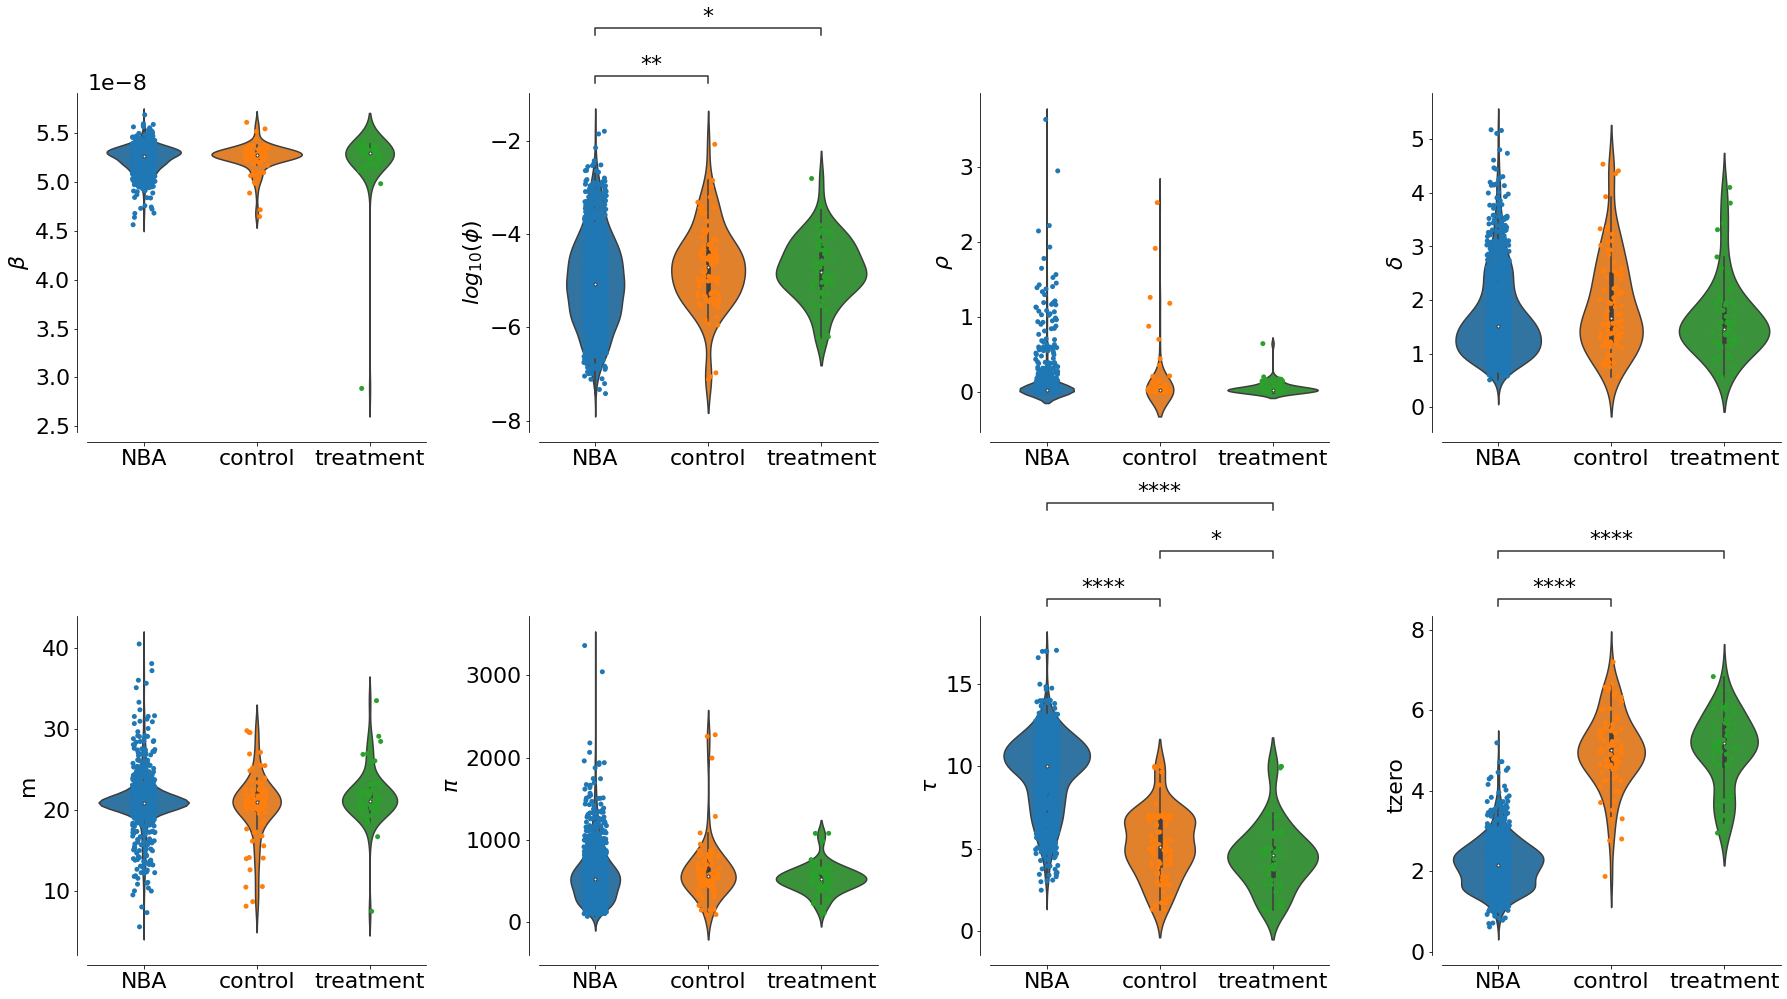

In [36]:
fig = plt.figure(figsize = (25,14))
plt.rcParams.update({'font.size': 22})
math_Sym = ['$\\beta$', '$log_{10}(\\phi)$', '$\\rho$', '$\\delta$', 'm', '$\\pi$', '$\\tau$', 'tzero']
for i, VLParam in enumerate(['beta', 'phi', 'rho', 'delta', 'm', 'pi', 'tau', 'tzero']):
    plt.subplot(2,4,i+1)
    ax = sns.stripplot(x='Cohort', y=VLParam, data = param_DF)
    ax = sns.violinplot(x='Cohort', y=VLParam, data = param_DF)
    if VLParam == 'phi' or VLParam == 'tzero': 
        annotator = Annotator(ax, 
                              [('NBA', 'PLATCOV_Cntrl'), ('NBA', 'PLATCOV_Trtmnt')], 
                              data=param_DF, x='Cohort', y=VLParam)
        annotator.configure(test = 'Mann-Whitney', comparisons_correction="bonferroni", 
                            loc='outside').apply_and_annotate()
    if VLParam == 'tau': 
        annotator = Annotator(ax, 
                              [('NBA', 'PLATCOV_Cntrl'), ('NBA', 'PLATCOV_Trtmnt'), 
                               ('PLATCOV_Cntrl','PLATCOV_Trtmnt')], 
                              data=param_DF, x='Cohort', y=VLParam)
        annotator.configure(test = 'Mann-Whitney', comparisons_correction="bonferroni", 
                            loc='outside').apply_and_annotate()
    sns.despine(offset=10, trim=False)
    ax.set_ylabel(math_Sym[i])
    ax.set_xlabel('')
    ax.set_xticklabels(['NBA', 'control', 'treatment'])

    for p in ax.patches:
        mybox =p
        color = mybox.get_facecolor()
        mybox.set_facecolor((0, 0, 0, 0))
        mybox.set_edgecolor('black')
plt.tight_layout(pad = 0.5)

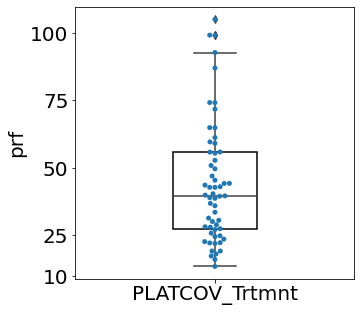

In [154]:
fig = plt.figure(figsize = (5,5))
plt.rcParams.update({'font.size': 20})
ax = sns.swarmplot(x='Cohort', y='prf', data = param_DF[param_DF.Cohort == 'PLATCOV_Trtmnt'])
ax = sns.boxplot(x='Cohort', y='prf', data = param_DF[param_DF.Cohort == 'PLATCOV_Trtmnt'], width=0.3)
ax.set_xlabel('')
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor('black')
ax.set_yticks([10,25,50,75,100])
#sns.despine(offset=10, trim=False)

In [21]:
prf = param_DF[param_DF.Cohort == 'PLATCOV_Trtmnt'].prf.values

In [23]:
prf_median = np.median(prf)
prf_median

39.78845

In [27]:
IQR_25 = np.percentile(prf, 25)
IQR_75 = np.percentile(prf, 75)
prf_min = np.min(prf)
prf_max = np.max(prf)

In [25]:
IQR_25

27.248025000000002

In [26]:
IQR_75

55.754525

In [28]:
prf_min

13.5109

In [29]:
prf_max

105.033